In [1]:
%matplotlib inline
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pylab as plt
import xmldataset
import requests
from collections import Counter
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import scipy as sp
from sklearn import linear_model, svm, metrics
from wordcloud import WordCloud
from IPython import display
import math
from datetime import datetime
matplotlib.pylab.rcParams['figure.figsize'] = (14,7)

In [2]:
xml_data_path="/home/salman/Downloads/DataIncubators/2018/datascience.stackexchange.com/Posts.xml"
usr_data_path="/home/salman/Downloads/DataIncubators/2018/datascience.stackexchange.com/Users.xml"
etree = ET.parse(xml_data_path)
usretree=ET.parse(usr_data_path)

In [3]:
data = []
for el in etree.iterfind('*'):
    data.append(dict(el.items()))

df = pd.DataFrame(data)

data = []
for el in usretree.iterfind('*'):
    data.append(dict(el.items()))

usrdf = pd.DataFrame(data)

data = []

In [4]:
for s in ['AcceptedAnswerId','AnswerCount','CommentCount','FavoriteCount','Id','LastEditorUserId','OwnerUserId',\
          'ParentId','PostTypeId','Score','ViewCount']:
    df[s]=pd.to_numeric(df[s],errors='coerce')
for s in ['CreationDate','ClosedDate','CreationDate','LastActivityDate','LastEditDate']:
    df[s]=pd.to_datetime(df[s],errors='coerce')
    
for s in ["Id","AccountId","Age","DownVotes","Reputation","UpVotes","Views"]:
    usrdf[s]=pd.to_numeric(usrdf[s],errors='coerce')

In [5]:
Qdf=df[df["PostTypeId"]==1]
Qdf=Qdf.reset_index(drop=True)

In [6]:
for i in range(Qdf.shape[0]):
    if not usrdf[usrdf["Id"]==(Qdf.iloc[i,14])].empty:
        Qdf.at[i,"Reputation"]=usrdf[usrdf["Id"]==(Qdf.iloc[i,14])].iloc[0,10]
    else:
        Qdf.at[i,"Reputation"]=0

In [7]:
Q_counter=Counter()
for i in df[df['PostTypeId']==1]['OwnerUserId']:
    Q_counter['%s'%i]+=1
A_counter=Counter()
for i in df[df['PostTypeId']==2]['OwnerUserId']:
    A_counter[i]+=1

In [8]:
AA_counter=Counter()
for i in df['AcceptedAnswerId'][df['AcceptedAnswerId'].notnull()]:
    for j in df[df['Id']==i]["OwnerUserId"]:
        AA_counter['%s'%j]+=1


In [9]:
stop = set(stopwords.words('english'))
myset=set(['*','-','.',':','#',',','|',"i've","/",'$','$$','<','>','+','=','==','&','1,','10','11','?','0,','0.','','<-','also',"i'm",'nan'])
for i in range(13):
    stop.update('%s'%i)
stop.update(myset)

BodyWord_counter=Counter()
for i in Qdf['Body']:
    ii=BeautifulSoup(i, 'html.parser').findAll(text=True)
    for b in ii:
        for word in b.lower().split():
            if word not in stop:
                BodyWord_counter[word] += 1

In [10]:
Title_counter=Counter()
for i in Qdf['Title']:
    ii=BeautifulSoup('%s'%i, 'html.parser').findAll(text=True)
    for b in ii:
        for word in b.lower().split():
            if word not in stop:
                Title_counter[word] += 1

In [11]:
Tags_counter=Counter()
for i in Qdf[Qdf['Tags'].notnull()]['Tags']:
    for word in i.split("<"):
        if word not in stop:
            Tags_counter[word[:-1]] += 1

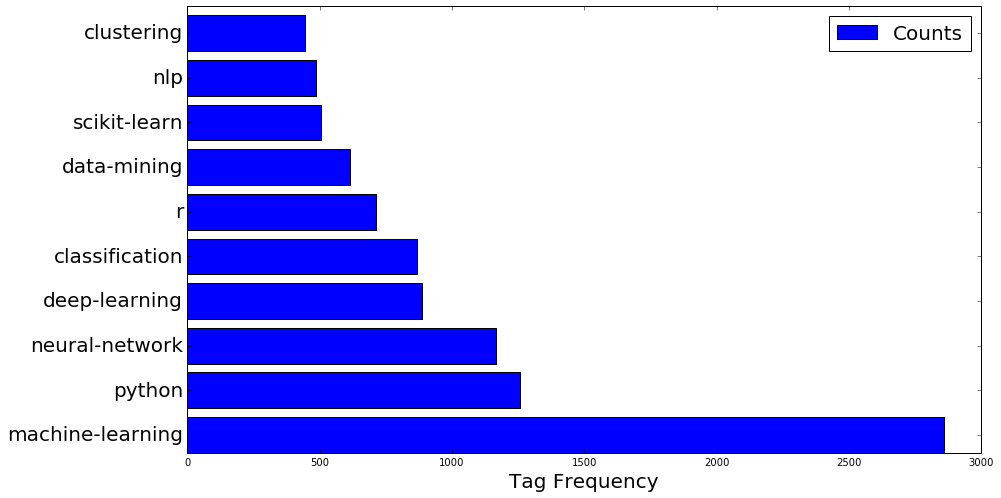

In [12]:
Tags_counter.items()
Tag_labels, Tag_values = zip(*Tags_counter.most_common(10))
Tag_indexes = np.arange(len(Tag_labels))
width = 0.8
plt.barh(Tag_indexes, Tag_values, width)
plt.yticks(Tag_indexes + width * 0.5, Tag_labels,rotation=0,fontsize=(20))
plt.xlabel('Tag Frequency',fontsize=20)
plt.legend({'Counts'},fontsize=(20))
plt.tight_layout()
plt.savefig("/home/salman/Downloads/DataIncubators/2018/fig1.jpg")
plt.show()

In [13]:
a,b=zip(*Tags_counter.most_common(100))
newDic=set(a)
a,b=zip(*BodyWord_counter.most_common(300))
newDic.update(set(a))
a,b=zip(*Title_counter.most_common(200))
newDic.update(set(a))

In [14]:
t=0
Dic2Num={}
for i in newDic:
    Dic2Num["%s"%i]=t
    t+=1

In [15]:
#The prototype size of the sample and the arrray is not big and so I omitted the use of sparse matrices.
BodyArray=np.zeros((Qdf.shape[0],len(newDic)))
for i in range(Qdf.shape[0]):
    ii=BeautifulSoup(Qdf.Body[i], 'html.parser').findAll(text=True)
    for b in ii:
        for word in b.lower().split():
            if word not in stop:
                if word in newDic:
                    BodyArray[i,Dic2Num[word]]+=1

In [16]:
t=0
for i in range(Qdf.shape[0]):
    for word in Qdf.Tags[i].split("<"):
        if word[:-1] not in stop:
            if word[:-1] in newDic:
                t+=1
    Qdf.at[i,"CountTags"]=t
    t=0

In [17]:
t=0
for i in range(Qdf.shape[0]):
    ii=BeautifulSoup(Qdf.Title[i], 'html.parser').findAll(text=True)
    for b in ii:
        for word in b.lower().split():
            if word not in stop:
                if word in newDic:
                    t+=1
    Qdf.at[i,"CountTitles"]=t
    t=0

In [18]:
dtemp=pd.DataFrame(np.log(Qdf.Reputation-Qdf.Reputation.min()+1))
dtemp["Score"]=np.log(Qdf.Score-Qdf.Score.min()+1)
#dtemp["CountBody"]=Qdf.CountBody/50.0

In [19]:
Qdf["Reputation"]=dtemp["Reputation"]
#Qdf["Score"]=dtemp["Score"]
#Qdf["CountBody"]=dtemp["CountBody"]
dtemp=0

# Here the non-random cut is intentional, since the ultimate goal would be predict value of new Questions

In [20]:
Traindf=Qdf.loc[:6500]
Testdf=Qdf.loc[6501:]
TrainX=BodyArray[:6501]
TestX=BodyArray[6501:]

In [21]:
Xtrain=Traindf.filter(["Reputation","CountBody","CountTags","CountTitles"], axis=1)
XTest=Testdf.filter(["Reputation","CountBody","CountTags","CountTitles"], axis=1)
Ytrain=Traindf.filter(["Score"])
YTest=Testdf.filter(["Score"])

In [22]:
clf = linear_model.Ridge()
clf.fit(TrainX,Ytrain)
print(metrics.explained_variance_score(YTest,clf.predict(TestX)),\
    'MAE=',metrics.mean_absolute_error(YTest,clf.predict(TestX)),\
    'MSE=',metrics.mean_squared_error(YTest,clf.predict(TestX)),\
    metrics.median_absolute_error(YTest,clf.predict(TestX)),\
   'r2=', metrics.r2_score(YTest,clf.predict(TestX)),"\n")

-0.9353754907822525 MAE= 1.9870111026412085 MSE= 6.625110500272881 1.673833277129236 r2= -1.6789912121064074 



In [23]:
lm = linear_model.LinearRegression()
model = lm.fit(Xtrain,Ytrain)
Predictions=lm.predict(XTest)
print('MAE=',metrics.mean_absolute_error(YTest,lm.predict(XTest)),\
      'MSE=',metrics.mean_squared_error(YTest,lm.predict(XTest)),\
      'r2=',metrics.r2_score(YTest,lm.predict(XTest)),"\n")

MAE= 1.5931324759906471 MSE= 4.4623040738780695 r2= -0.8044187186271952 



In [24]:
for i in [0.01,0.02,0.03,0.04,0.05]:
    svmSVR=svm.SVR(C=i)
    svmSVR.fit(TrainX,Ytrain.values.ravel())
    print('MAE=',metrics.mean_absolute_error(YTest,svmSVR.predict(TestX)),\
          'MSE=',metrics.mean_squared_error(YTest,svmSVR.predict(TestX)),\
          'r2=', metrics.r2_score(YTest,svmSVR.predict(TestX)),"\n")

MAE= 1.0142547215174227 MSE= 2.487892398952501 r2= -0.006027276554187777 

MAE= 1.0225551498415684 MSE= 2.4864960300494032 r2= -0.005462627855859603 

MAE= 1.0309197445017901 MSE= 2.4869864614347605 r2= -0.005660943245687555 

MAE= 1.0392610442051748 MSE= 2.4892996132839644 r2= -0.006596310810655481 

MAE= 1.0477119202403358 MSE= 2.493437655929837 r2= -0.008269608166700637 



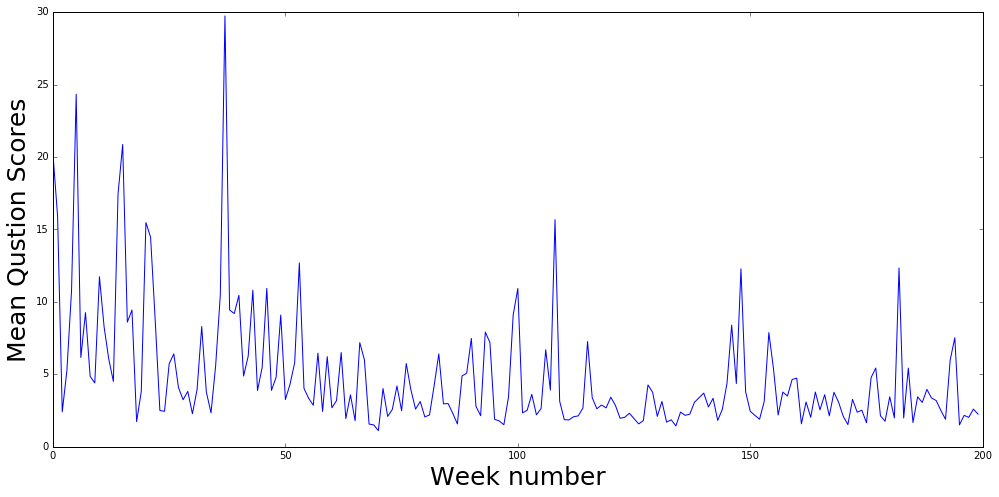

In [26]:
reQdf=df.groupby((Qdf["CreationDate"]-Qdf["CreationDate"][0]).dt.total_seconds() // (3600*24*7),as_index=False).std()
plt.plot(reQdf["Score"])
plt.xlabel(r"Week number",fontsize=25)
plt.ylabel("Mean Qustion Scores",fontsize=25)
plt.tight_layout()
plt.savefig("/home/salman/Downloads/DataIncubators/2018/fig2.jpg")

# My scratch starts from here!

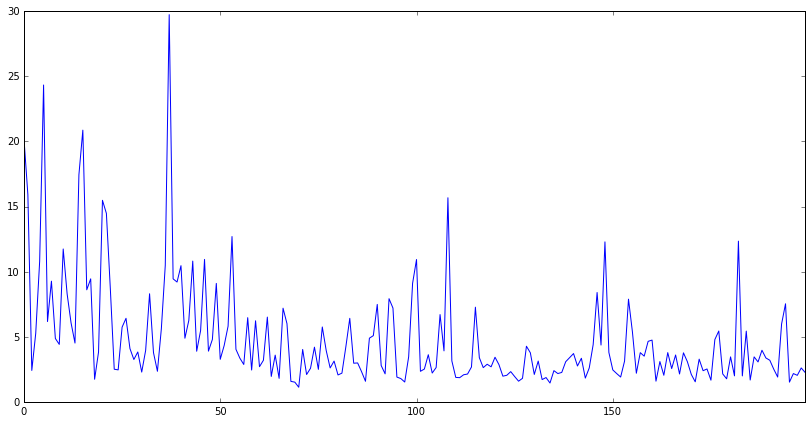

In [51]:
reQdf=df.groupby((Qdf["CreationDate"]-Qdf["CreationDate"][0]).dt.total_seconds() // (3600*24*7),as_index=False).std()
reQdf["Score"].plot()

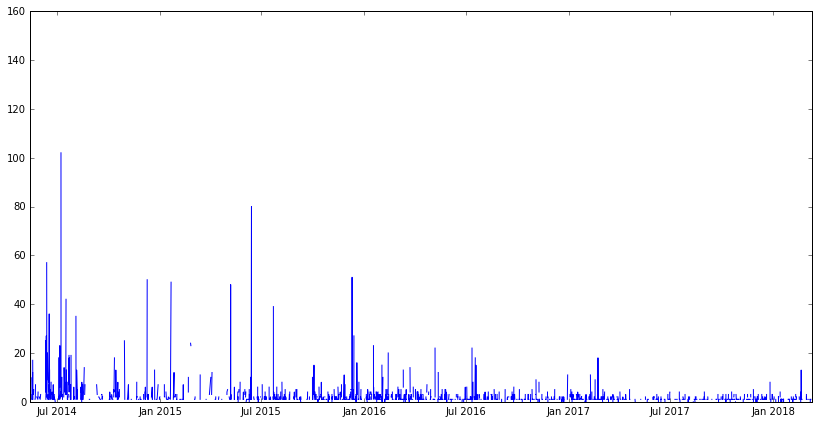

In [37]:
ValueVariable=["FavoriteCount","Score","ViewCount","AnswerCount","CommentCount"]
i=0
plt.plot(Qdf["CreationDate"],(Qdf["%s"%ValueVariable[i]]))

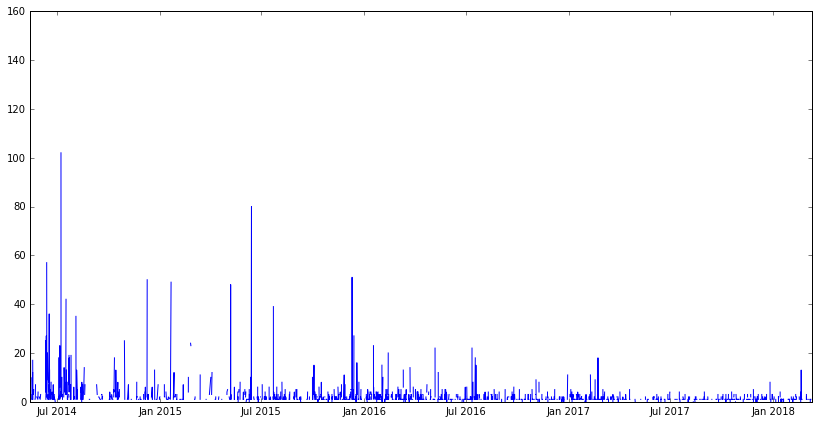

In [29]:
ValueVariable=["FavoriteCount","Score","ViewCount","AnswerCount","CommentCount"]
i=0
#plt.plot(Qdf["CreationDate"],(Qdf["%s"%ValueVariable[i]]-Qdf["%s"%ValueVariable[i]].mean())/Qdf["%s"%ValueVariable[i]].std())
plt.plot(Qdf["CreationDate"],(Qdf["%s"%ValueVariable[i]]))#-Qdf["%s"%ValueVariable[i]].mean())/Qdf["%s"%ValueVariable[i]].std())


In [42]:
pd.DataFrame.plot?

In [ ]:
plt.scatter(TrainX,Ytrain.values.ravel())

In [ ]:
#Baltadzhieva, A. and Chrupała, G., 2015. Predicting the quality of questions on stackoverflow.
#In Proceedings of the International Conference Recent Advances in Natural Language Processing (pp. 32-40).

In [32]:
i=0.02
svmSVR=svm.SVR(C=i)
svmSVR.fit(TrainX,Ytrain.values.ravel())


SVR(C=0.02, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

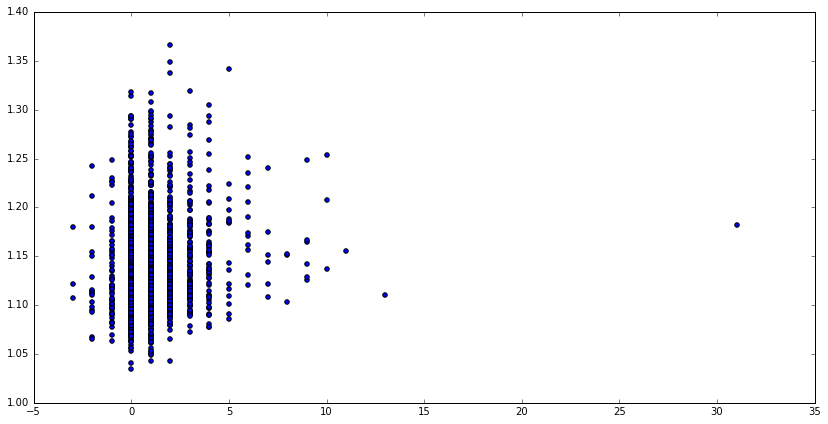

In [33]:
plt.scatter(YTest,svmSVR.predict(TestX))

In [74]:
#plt.scatter(Ytrain,svmclf.predict(TrainX))

In [26]:
for i in [0.0000001,0.000003,0.00001,0.00003,0.0001,0.0003]:
    svmclf=svm.LinearSVC(C=i)
    svmclf.fit(TrainX,Ytrain.values.ravel())
    print(metrics.explained_variance_score(YTest,svmclf.predict(TestX)),\
    'MAE=',metrics.mean_absolute_error(YTest,svmclf.predict(TestX)),\
    'MSE=',metrics.mean_squared_error(YTest,svmclf.predict(TestX)),\
    metrics.median_absolute_error(YTest,svmclf.predict(TestX)),\
   'r2=', metrics.r2_score(YTest,svmclf.predict(TestX)),"\n")

NameError: name 'TrainX' is not defined

In [75]:
#plt.scatter(YTest,svmclf.predict(TestX))

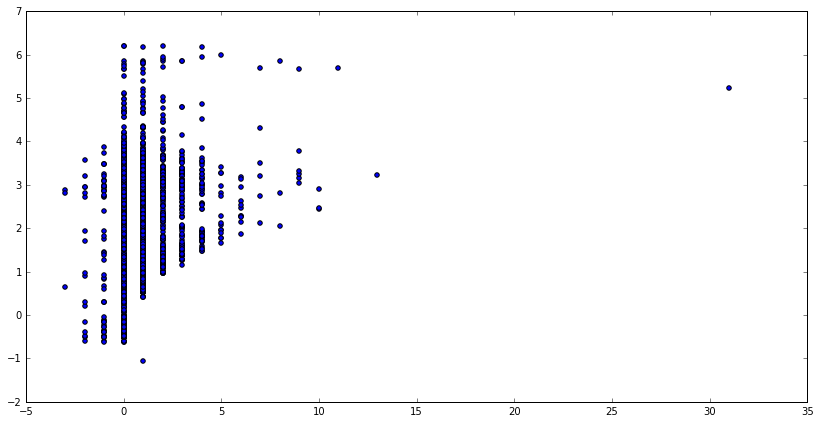

In [58]:
plt.scatter(YTest, Predictions)
#plt.xlabel(“True Values”)
#plt.ylabel(“Predictions”)

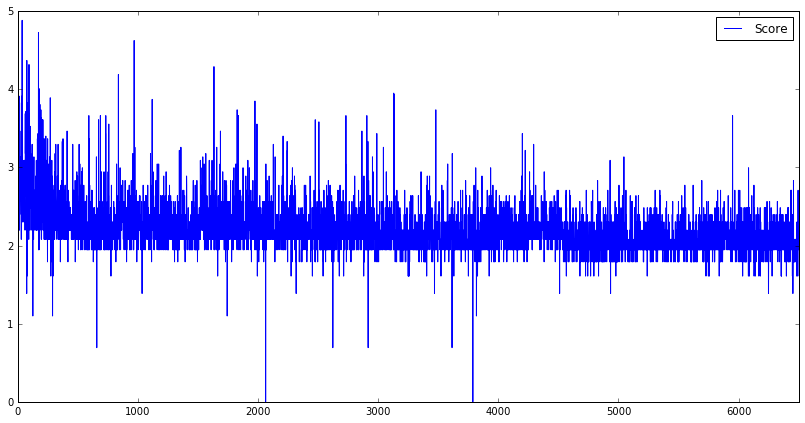

In [53]:
Ytrain.plot()

In [22]:
with open("onlineldavb-master/dictnostops.txt") as fh:
    words = [line.strip() for line in fh.readlines()]
    word_to_index = { word: k for k, word in enumerate(words) }
    


In [6]:
#usrdf.sort_values(by=['Id']);

In [207]:
reQdf=df.groupby((Qdf["CreationDate"]-Qdf["CreationDate"][0]).dt.total_seconds() // (3600*24*7),as_index=False).std()
reQdf["Score"].plot()

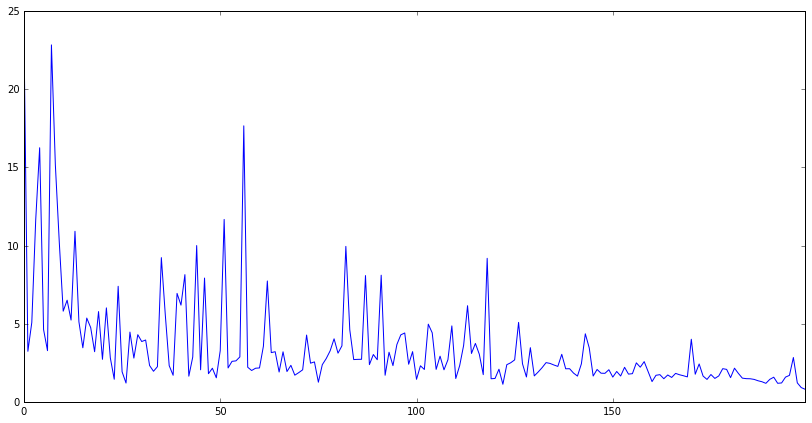

In [211]:
reQdf["Score"].plot()

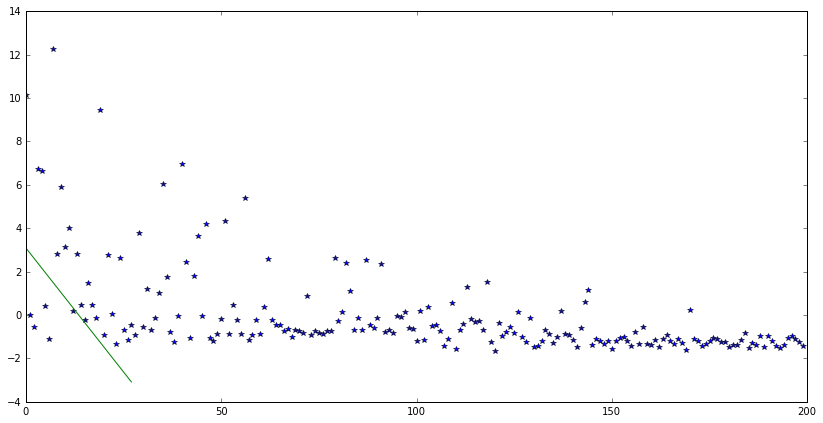

In [205]:
ValueVariable=["FavoriteCount","Score","ViewCount","AnswerCount","CommentCount"]
#ValueFit={}
i=0
plt.plot((reQdf["%s"%ValueVariable[i]]-reQdf["%s"%ValueVariable[i]].mean()),"*")#/reQdf["%s"%ValueVariable[i]].std())
plt.plot(np.arange(0,28),ValueFit(np.arange(0,28)))

In [196]:
#sp.stats.linregress
#ValueFit=
i=1
#ValueFit=np.poly1d(np.polyfit(np.arange(0,28),(reQdf["%s"%ValueVariable[i]]-reQdf["%s"%ValueVariable[i]].\
#                                        mean())/reQdf["%s"%ValueVariable[i]].std(),2))
ValueFit=np.poly1d(np.polyfit(np.arange(0,28),(reQdf["%s"%ValueVariable[i]]-reQdf["%s"%ValueVariable[i]].mean()),1))


In [197]:
np.polyfit(np.arange(0,28),(reQdf["%s"%ValueVariable[i]]-reQdf["%s"%ValueVariable[i]].mean()),1)

array([-0.22855766,  3.08552847])

In [161]:
sp.stats.linregress(np.arange(0,1340),(reQdf["%s"%ValueVariable[i]]-reQdf["%s"%ValueVariable[i]].\
                                        mean())/reQdf["%s"%ValueVariable[i]].std())

LinregressResult(slope=-0.0012100595593729148, intercept=0.8101348750001667, rvalue=-0.4682555267473864, pvalue=5.657157312219767e-74, stderr=6.242349674899828e-05)

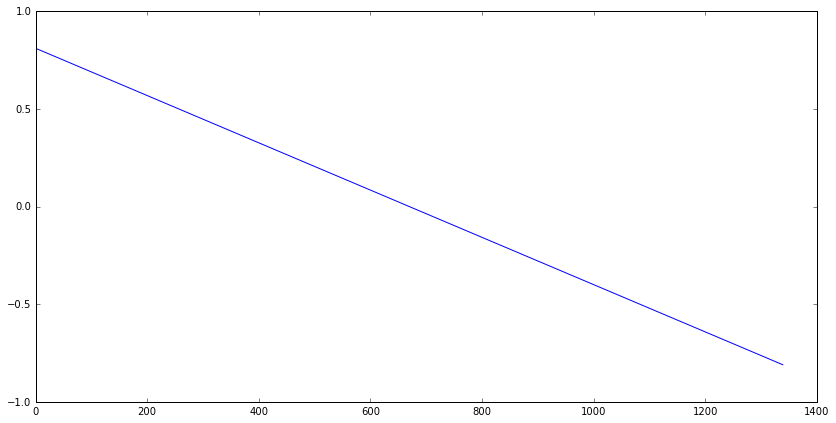

In [162]:
plt.plot(np.arange(0,1340),ValueFit(np.arange(0,1340)))

In [ ]:
I should Drop the ones that are more than (2) std away, and then find a line to shift

In [ ]:
# Get the rows to split.
split_rows = (df['start_date'].dt.date != df['end_date'].dt.date)

# Get the new rows to append, adjusting the start_date to the next day.
new_rows = df[split_rows].copy()
new_rows['start_date'] = new_rows['start_date'].dt.date + pd.DateOffset(days=1)

# Adjust the end_date of the existing rows.
df.loc[split_rows, 'end_date'] = df.loc[split_rows, 'start_date'].dt.date + pd.DateOffset(days=1, seconds=-1)

# Append the new rows to the existing dataframe.
df = df.append(new_rows).sort_index().reset_index(drop=True)

In [156]:
#for i in df['Body']:
#    print(i.lower().split())

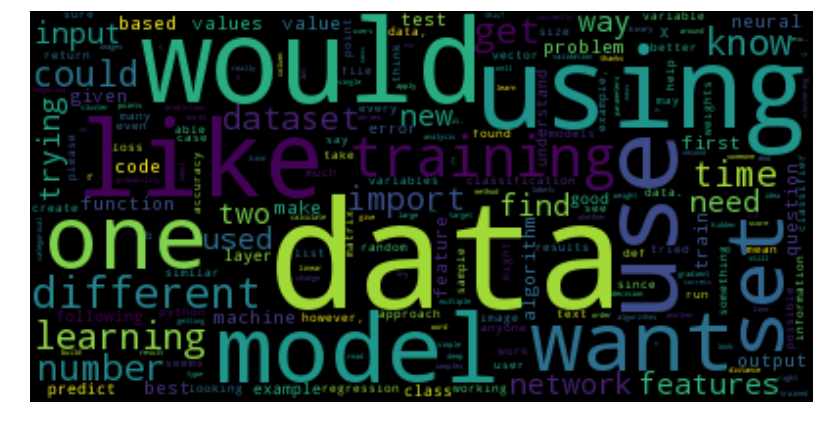

In [10]:
wordcloud = WordCloud().fit_words(BodyWord_counter)
plt.axis("off")
plt.imshow(wordcloud)

In [4]:
#df.loc[df['Id'] == '9'].iloc[0][2]

In [5]:
#df.loc[df['Id'] == '9']

In [63]:
#df[df['Tags'].notnull()]  #8612 with tag same as df[df['PostTypeId']=='1'] same as TEMp=df[df['AnswerCount'].notnull()]
# 19213 the whole df

In [83]:
TEMp=df[df['AnswerCount'].notnull()] # 8612 again! 
#TEMp[TEMp['AnswerCount']!='0']  # 6484

In [25]:
#TEMp.describe()

In [92]:
TEMp2=pd.to_numeric(TEMp['AnswerCount'])
TEMp2.sum()

10329

In [8]:
#list(df)

['AcceptedAnswerId',
 'AnswerCount',
 'Body',
 'ClosedDate',
 'CommentCount',
 'CreationDate',
 'FavoriteCount',
 'Id',
 'LastActivityDate',
 'LastEditDate',
 'LastEditorUserId',
 'OwnerUserId',
 'ParentId',
 'PostTypeId',
 'Score',
 'Tags',
 'Title',
 'ViewCount']

In [18]:
df.describe()

,AcceptedAnswerId,AnswerCount,CommentCount,FavoriteCount,Id,LastEditorUserId,OwnerUserId,ParentId,PostTypeId,Score,ViewCount
count,3006.000000,8612.000000,19213.000000,2822.000000,19213.000000,7049.000000,19159.000000,10329.000000,19213.000000,19213.000000,8612.000000
mean,15563.750166,1.199373,1.117577,2.340893,15857.630459,17028.162860,19916.636255,14230.637235,1.587519,2.186072,743.101602
std,7939.392527,1.184554,1.886723,5.421152,8071.639013,14092.891361,14008.510451,8195.549467,0.610397,4.288569,3123.626366
min,10.000000,0.000000,0.000000,0.000000,5.000000,-1.000000,-1.000000,5.000000,1.000000,-6.000000,2.000000
25%,9740.750000,1.000000,0.000000,1.000000,9756.000000,1424.000000,8820.000000,8322.000000,1.000000,0.000000,49.000000
50%,15417.500000,1.000000,0.000000,1.000000,15882.000000,14313.000000,17355.000000,13744.000000,2.000000,1.000000,119.000000
75%,22776.500000,2.000000,2.000000,2.000000,23179.000000,29575.000000,30472.000000,20403.000000,2.000000,3.000000,395.000000
max,28909.000000,32.000000,25.000000,150.000000,28933.000000,47540.000000,47578.000000,28929.000000,7.000000,125.000000,83843.000000


In [4]:
#soup = BeautifulSoup(df['Body'][5], 'html.parser')
#soup.findAll(text=True)[0]

'In which situations would one system be preferred over the other? What are the relative advantages and disadvantages of relational databases versus non-relational databases?'

In [165]:
stop = set(stopwords.words('english'))
counter=Counter()
t=0
for i in df['Body']:
    ii=BeautifulSoup(df['Body'][t], 'html.parser').findAll(text=True)
    t+=1
    for b in ii:
        for word in b.lower().split():
            if word not in stop:
                counter[word] += 1

In [166]:
def nlargest(n, word_scores):
    return heapq.nlargest(n, word_scores, key=lambda x: x[1])

sys.stdout.write("\r" + str(nlargest(20, counter.items())))

[('=', 22122), ('data', 17484), ('use', 9194), ('would', 8945), ('using', 7743), ('model', 7371), ('one', 7106), ('like', 6686), ('1', 6485), ('-', 6162), ('0', 5594), ('.', 5557), ('want', 5210), ('learning', 4734), ('training', 4687), ('set', 4551), ('could', 4484), ('different', 4391), ('0,', 4361), ('#', 4241)]

In [32]:
nlargest(10, counter.items())#['python']

[('data', 9),
 ('elements', 4),
 ('particular', 4),
 ('machine', 4),
 ('obstacles', 3),
 ('would', 3),
 ('one', 3),
 ('analysis', 3),
 ('modelling', 3),
 ('example,', 3)]

In [55]:
counter=Counter()
for i in df['AcceptedAnswerId']:
    counter['%s'%i]+=1

In [65]:
df['Id'].loc(counter.most_common(10)[1][0])

In [154]:
for i in df[df['Id']==10]['Body']:
    print(BeautifulSoup(i, 'html.parser').findAll(text=True))

['One book that\'s freely available is "The Elements of Statistical Learning" by Hastie, Tibshirani, and Friedman (published by Springer): ', "see Tibshirani's website", '.', '\n', "Another fantastic source, although it isn't a book, is Andrew Ng's Machine Learning course on Coursera. This has a much more applied-focus than the above book, and Prof. Ng does a great job of explaining the thinking behind several different machine learning algorithms/situations.", '\n']


In [145]:
#df['AcceptedAnswerId'][df['AcceptedAnswerId'].notnull()]
df[df["Id"]==10]

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,LastActivityDate,...,LastEditorDisplayName,LastEditorUserId,OwnerDisplayName,OwnerUserId,ParentId,PostTypeId,Score,Tags,Title,ViewCount
3,NaN,NaN,"<p>One book that's freely available is ""The El...",NaN,1,NaN,2014-05-14T00:53:43.273,NaN,10,2014-05-14T00:53:43.273,...,NaN,NaN,NaN,22.0,7.0,2,12,NaN,NaN,NaN


In [167]:
df[df['Id']==7]

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,LastActivityDate,...,LastEditorDisplayName,LastEditorUserId,OwnerDisplayName,OwnerUserId,ParentId,PostTypeId,Score,Tags,Title,ViewCount
1,10.0,3.0,"<p>As a researcher and instructor, I'm looking...",2014-05-14T08:40:54.950,4,NaN,2014-05-14T00:11:06.457,1.0,7,2014-05-16T13:45:00.237,...,NaN,97.0,NaN,36.0,NaN,1,4,<education><open-source>,What open-source books (or other materials) pr...,363.0


In [16]:
df.dtypes

AcceptedAnswerId                float64
AnswerCount                     float64
Body                             object
ClosedDate               datetime64[ns]
CommentCount                      int64
CommunityOwnedDate               object
CreationDate             datetime64[ns]
FavoriteCount                   float64
Id                                int64
LastActivityDate         datetime64[ns]
LastEditDate             datetime64[ns]
LastEditorDisplayName            object
LastEditorUserId                float64
OwnerDisplayName                 object
OwnerUserId                     float64
ParentId                        float64
PostTypeId                        int64
Score                             int64
Tags                             object
Title                            object
ViewCount                       float64
dtype: object

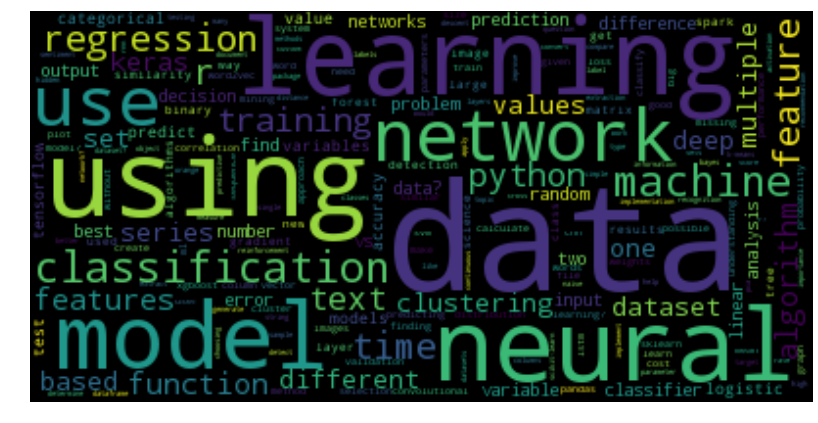

In [12]:
wordcloud = WordCloud().fit_words(Title_counter)
plt.axis("off")
plt.imshow(wordcloud)

In [30]:
svm.SVR?

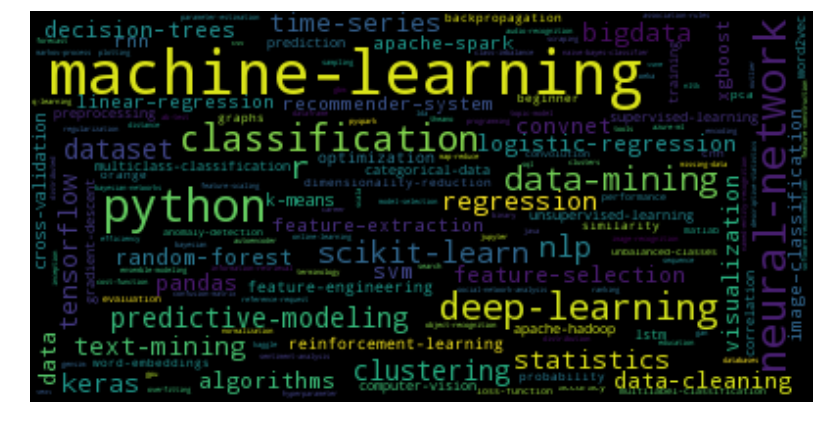

In [14]:
wordcloud = WordCloud().fit_words(Tags_counter)
plt.figure(figsize=(15,7))
plt.axis("off")
plt.imshow(wordcloud)